In [4]:
import os
import sys
import shutil
import random
import zipfile
# from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm import tqdm

In [5]:
root_dir = os.path.dirname(os.getcwd())

if root_dir not in sys.path:
    sys.path.append(root_dir)

import config

In [6]:
data_source_path = config.model_data_source_path
data_target_path = config.model_data_target_path

In [7]:
image_size = (700, 700)

In [31]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*image_size, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (2,2), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (1,1), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (2,2), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 698, 698, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 349, 349, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 348, 348, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 174, 174, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 172, 172, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 86, 86, 128)       0

In [33]:
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

In [34]:
batch_size=32

In [35]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_target_path, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_target_path, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 48000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


In [36]:
class_indices = train_generator.class_indices
print(class_indices)

{'digital': 0, 'film': 1}


In [37]:
total_train_images = train_generator.n
total_val_images = val_generator.n

In [38]:
steps_per_epoch = math.ceil(total_train_images // batch_size)
validation_steps = math.ceil(total_val_images // batch_size)

In [39]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [40]:
checkpoint = ModelCheckpoint(
    os.path.join(config.model_checkpoints_path, 'checkpoint_{epoch:02d}-{val_accuracy:.2f}.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

In [42]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks = [early_stopping, checkpoint]
)

Epoch 1/30
1500/1500 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.6638
Epoch 1: val_accuracy improved from -inf to 0.66542, saving model to /content/drive/My Drive/DSI/results/checkpoint_01-0.67.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 828s 543ms/step - loss: 0.6335 - accuracy: 0.6638 - val_loss: 0.6027 - val_accuracy: 0.6654
Epoch 2/30
1500/1500 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.6892
Epoch 2: val_accuracy improved from 0.66542 to 0.70000, saving model to /content/drive/My Drive/DSI/results/checkpoint_02-0.70.h5
1500/1500 [==============================] - 806s 537ms/step - loss: 0.6083 - accuracy: 0.6892 - val_loss: 0.5800 - val_accuracy: 0.7000
Epoch 3/30
1500/1500 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.7010
Epoch 3: val_accuracy improved from 0.70000 to 0.71833, saving model to /content/drive/My Drive/DSI/results/checkpoint_03-0.72.h5
1500/1500 [==============================] - 804s 536ms/step - loss: 0.5942 - accuracy: 0.7010 - val_loss: 0.5695 - val_accuracy: 0.7183
Epoch 4/30
1500/1500 [==============================] - ETA: 0s - loss: 0.5836 - accuracy: 0.7155
Epoch 4: val_accuracy improved from

In [43]:
model.evaluate(val_generator)

375/375 [==============================] - 159s 423ms/step - loss: 0.4487 - accuracy: 0.8347


[0.4486593008041382, 0.8346666693687439]

In [99]:
model.save('/content/drive/My Drive/DSI/capstone/results/60_000_epoch30_.83.png.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [100]:
import json

# Convert the history.history dict to a JSON file
with open('/content/drive/My Drive/DSI/capstone/results/60_000_700_history.json', 'w') as f:
    json.dump(history.history, f)

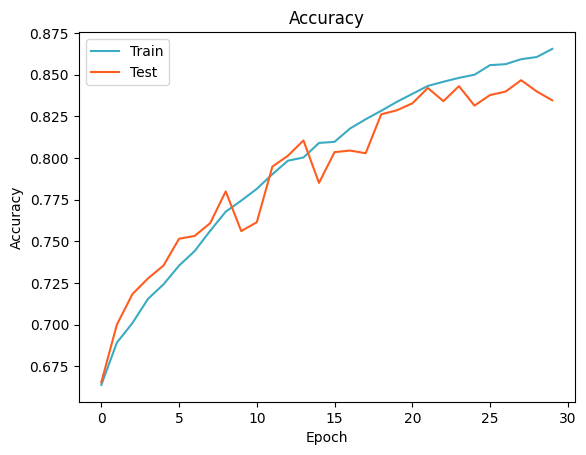

In [97]:
# output_path = '/content/drive/My Drive/DSI/results/accuracy_plot.png'
plt.plot(history.history['accuracy'], label = 'Train', color = '#3babc1')
plt.plot(history.history['val_accuracy'], label = 'Test', color = '#fe5d1f')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig(output_path, dpi=300, transparent=False);


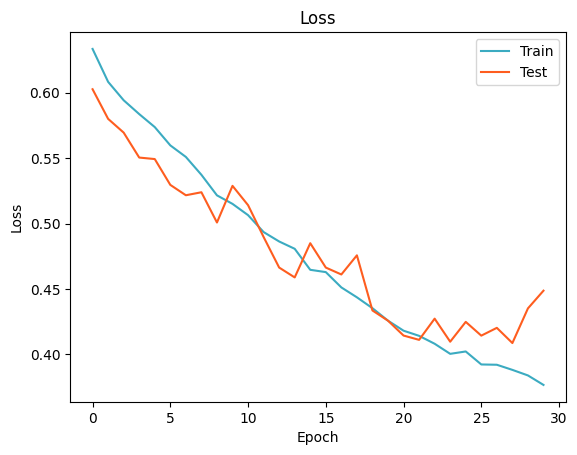

In [98]:
# output_path = '/content/drive/My Drive/DSI/results/loss_plot.png'
plt.plot(history.history['loss'], label = 'Train', color = '#3babc1')
plt.plot(history.history['val_loss'], label = 'Test', color = '#fe5d1f')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(output_path, dpi=300, transparent=False);


In [46]:
val_generator.reset()
num_val_samples = val_generator.samples

In [47]:
predictions = model.predict(val_generator, steps=validation_steps, )

375/375 [==============================] - 159s 422ms/step


In [48]:
predictions = (predictions > 0.5).astype('int32')

In [49]:
true_labels = val_generator.classes

In [50]:
cm = confusion_matrix(true_labels, predictions)

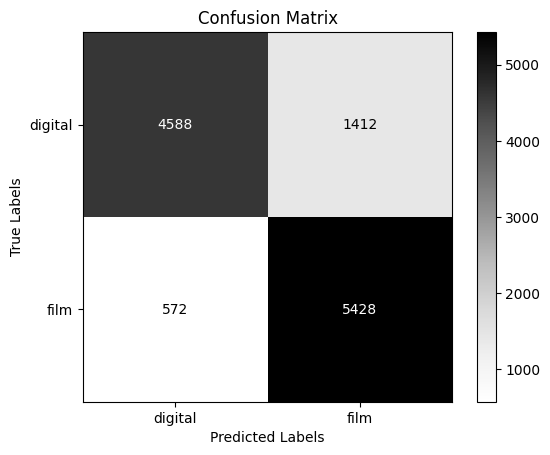

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap='Greys')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()